# BigDFT Fragmentation 

In this notebook we will go through the steps needed for computing the purity indicator and spillage values. First, we define the calculator we will use.

In [1]:
from BigDFT import Calculators as C

In [2]:
code = C.SystemCalculator(omp=2, mpi_run="mpirun")

Initialize a Calculator with OMP_NUM_THREADS=2 and command mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/bin/bigdft


In [3]:
code.update_global_options(skip=True)

We will store the results and inputs in a dictionary for naming ease.

In [4]:
class Result:
    def __init__(self, log=None, system=None, inp=None):
        self.log = log
        self.system = system
        self.inp = inp

In [5]:
rundir = "spillage_dir"

## Setup Calculation

First we define the system, which will be three water molecules. Two are close to one and other.

In [6]:
positions ="""
- O: [-0.931477999671, 0.004547999723, -0.117331000086]
- H: [-1.355753693973, -0.032108553467, 0.725181911626]
- H: [-0.003078395366, 0.011003111969, 0.053703839371]

- O: [1.500000000000, -0.003706000000, 0.113495000000]
- H: [1.796831000000, 0.762122000000, -0.351887000000]
- H: [1.773536000000, -0.747744000000, -0.399151000000]

- O: [10.500000000000, -0.003706000000, 0.113495000000]
- H: [10.796831000000, 0.762122000000, -0.351887000000]
- H: [10.773536000000, -0.747744000000, -0.399151000000]
"""

In [7]:
from futile import YamlIO as Y
posinp = {"positions": Y.load(stream=positions, doc_lists=False),
          "units":"angstroem"}

We will next define an input file for doing a calculation. For reference, let's do a run using both the linear and the cubic scaling version.

In [8]:
from BigDFT import Inputfiles as I

In [9]:
full = Result()
full.inp = I.Inputfile()
full.inp.set_xc("PBE")
full.inp.set_hgrid(0.4)
full.inp.write_orbitals_on_disk()
full.inp.calculate_dipole()
full.inp["import"] = "linear"
full.inp["posinp"] = posinp

In [10]:
full.log = code.run(name="full", input=full.inp, run_dir=rundir)

Creating the yaml input file "spillage_dir/full.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/bin/bigdft -n full -s Yes


## Fragmentation Study
First we need to divide the system up into fragments. First, we will show what happens when try fragmenting the system based on atoms.

In [11]:
from BigDFT import Fragments as F
reload(F)
from BigDFT import PostProcessing as PP
reload(PP)
btool = PP.BigDFTool()

In [12]:
full.system = F.System(mp_dict=full.log.electrostatic_multipoles, nat_reference=1)

In [13]:
btool.set_fragment_multipoles(full.system, full.log)

In [14]:
def plot_purity(system):
    from matplotlib import pyplot as plt
    from matplotlib.ticker import MaxNLocator
    
    frag_id = list(range(1, len(system.fragments)+1))
    purity_values = [x.purity_indicator for x in system.fragments]
    
    fig, axs = plt.subplots(1,1)
    axs.plot(frag_id, purity_values, 'x--')
    axs.set_xlabel("Fragment ID")
    axs.set_ylabel("Purity Value")
    axs.xaxis.set_major_locator(MaxNLocator(integer=True))

In [15]:
plot_purity(full.system)

Clearly the choice of atoms as a partitioning of the system is inadequate. Instead, we can refragment based on actual water molecules.

In [16]:
full.system = F.System(mp_dict=full.log.electrostatic_multipoles, nat_reference=3)

In [17]:
btool.set_fragment_multipoles(full.system, full.log)

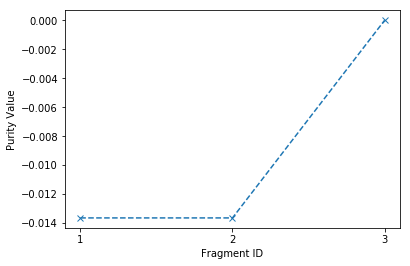

In [18]:
plot_purity(full.system)

Indeed we see that the water molecules themselves are much purer than the individual atoms, making them much more suitable fragments of a system. 

## QM/MM Setup
Now let's assume that we want to do a a QM/MM calculation that accurately computes the values associated with the first water molecule. First, let's do a pure calculation where we only treat the first water molecule in a QM way. First we partition, and then use that to build a new input file.

In [19]:
def setup_qmmm(start, target):
    from copy import deepcopy
    env = deepcopy(start.system)
    QM=env.pop(target)
    MM=env.dict()
    
    qmmm = Result()
    qmmm.inp = deepcopy(start.inp)
    qmmm.inp["posinp"]= QM.get_posinp(units="angstroem")
    qmmm.inp["dft"]["external_potential"] = MM
    qmmm.inp["dft"]["qcharge"] = start.system.fragments[0].qcharge()
    
    return qmmm

In [20]:
qmmm = setup_qmmm(full, 0)
qmmm.log = code.run(name="qmmm", input=qmmm.inp, run_dir=rundir)

Creating the yaml input file "spillage_dir/qmmm.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/bin/bigdft -n qmmm -s Yes


We can compare the results by looking at the multipoles.

In [21]:
qmmm.system = F.System(mp_dict=qmmm.log.electrostatic_multipoles,  nat_reference=3)
btool.set_fragment_multipoles(qmmm.system, qmmm.log)

In [22]:
def plot_error(refsys, sysdict):
    from matplotlib import pyplot as plt
    from matplotlib.ticker import MaxNLocator
    from numpy import array, dot
    from numpy.linalg import norm
    from math import acos, pi
    
    mplabel = ["$q_{0}$", "$q_{1,-1}$", "$q_{1,0}$", "$q_{1,1}$",
              "$q_{2,-2}$", "$q_{2,-1}$", "$q_{2,0}$", "$q_{2,1}$", "$q_{2,2}$"]
    mplabel2 = ["$q_0$", "$q_1$", "$q_2$"]
    
    fig, axs = plt.subplots(1, 3, figsize=(14,3))
    axs[0].set_ylabel("Multipole Error (AU)",fontsize=12)
    axs[2].set_ylabel("Multipole Error (Degrees)",fontsize=12)
    
    axs[0].set_xticks(range(0,9))
    axs[0].set_xticklabels(mplabel)
    axs[1].set_xticks(range(0,3))
    axs[1].set_xticklabels(mplabel2)
    axs[2].set_xticks(range(0,2))
    axs[2].set_xticklabels(mplabel2[1:])
    
    axs[0].set_title("Absolute Deviation of Components")
    axs[1].set_title("Error in Norm")
    axs[2].set_title("Error in Angle")
        
    for name, sys2 in sysdict.items():
        errors = []
        norm_errors = []
        angle_errors = []
        for i in range(0, 3):
            refval = (array(refsys.fragments[0].Q(order=i)))
            sysval = (array(sys2.fragments[0].Q(order=i)))
            try:
                errval = [abs(x - y) for x, y in zip(refval, sysval)]
            except:
                errval = [abs(refval - sysval)]
            errors.extend(errval)
            norm_errors.append(norm(refval - sysval))
            if i > 0:
                try:
                    angle_errors.append(acos(dot(refval,sysval)/(norm(refval)*norm(sysval)))*180/pi)
                except:
                    angle_errors.append(0)
        axs[0].plot(errors, 'x--',label=name)
        axs[1].plot(norm_errors, 'x--',label=name)
        axs[2].plot(angle_errors, 'x--',label=name)
    axs[0].legend()
    plt.tight_layout()

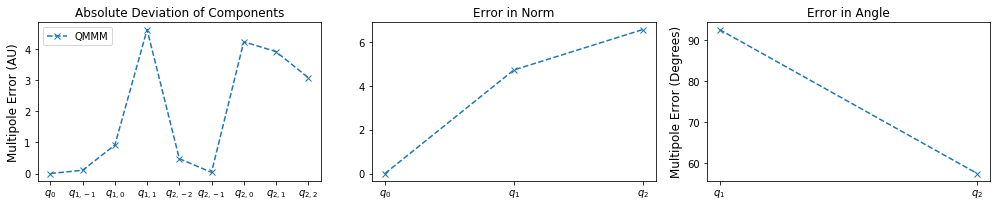

In [23]:
plot_error(full.system, {"QMMM":qmmm.system})

## Background Proof of Concept
We suspect that we can compute more accurate multipole values by including the second water in the QM region explicitly. Let's demonstrate this before thinking about buffer generation.

In [24]:
from copy import deepcopy
temp = deepcopy(full)
temp.system = F.System(mp_dict=temp.log.electrostatic_multipoles, frag_partition=[6, 9])
qmmm2 = setup_qmmm(temp, 0)
qmmm2.log = code.run(name="qmmm2", input=qmmm2.inp, run_dir=rundir)
qmmm2.system = F.System(mp_dict=qmmm2.log.electrostatic_multipoles,  nat_reference=3)
btool.set_fragment_multipoles(qmmm2.system, qmmm2.log)

Creating the yaml input file "spillage_dir/qmmm2.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/bin/bigdft -n qmmm2 -s Yes


Reference calculation rerun where we use the full system.

In [25]:
temp = deepcopy(full)
temp.system = F.System(mp_dict=temp.log.electrostatic_multipoles, frag_partition=[9])
qmmm3 = setup_qmmm(temp, 0)
qmmm3.log = code.run(name="qmmm3", input=qmmm3.inp, run_dir=rundir)
qmmm3.system = F.System(mp_dict=qmmm3.log.electrostatic_multipoles,  nat_reference=3)
btool.set_fragment_multipoles(qmmm3.system, qmmm3.log)

Creating the yaml input file "spillage_dir/qmmm3.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/bin/bigdft -n qmmm3 -s Yes


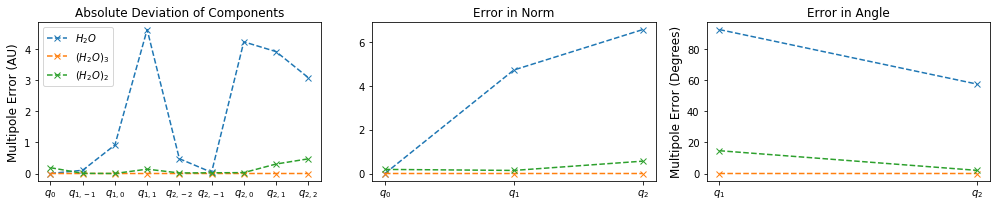

In [26]:
plot_error(full.system, {"$H_2O$":qmmm.system, "$(H_2O)_2$":qmmm2.system, "$(H_2O)_3$":qmmm3.system})

We need to be judicious in our choice of background. For example, let's rearrange the molecules in our calculation. Before, we had the first two water molecules be close to each other, while the third was far. In this calculation, the first second and third molecule are swapped.

In [27]:
posinp2 = deepcopy(posinp)
posinp2["positions"] = posinp["positions"][0:3] + posinp["positions"][6:9] + posinp["positions"][3:6]
reorder = Result()
reorder.inp = deepcopy(full.inp)
reorder.inp["posinp"] = posinp2
reorder.log = code.run(name="reorder", input=reorder.inp, run_dir=rundir)
reorder.system = F.System(mp_dict=reorder.log.electrostatic_multipoles,  nat_reference=3)
btool.set_fragment_multipoles(reorder.system, reorder.log)

Creating the yaml input file "spillage_dir/reorder.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/bin/bigdft -n reorder -s Yes


The effect of this swapping is that when we build the QMMM calculation, and include the second water molecule in the buffer region, we are now including the far water molecule, not the close.

In [28]:
rmmm = setup_qmmm(reorder, 0)
rmmm.log = code.run(name="rmmm", input=rmmm.inp, run_dir=rundir)
rmmm.system = F.System(mp_dict=rmmm.log.electrostatic_multipoles,  nat_reference=3)
btool.set_fragment_multipoles(rmmm.system, rmmm.log)

temp = deepcopy(reorder)
temp.system = F.System(mp_dict=temp.log.electrostatic_multipoles, frag_partition=[6, 9])
rmmm2 = setup_qmmm(temp, 0)
rmmm2.log = code.run(name="rmmm2", input=rmmm2.inp, run_dir=rundir)
rmmm2.system = F.System(mp_dict=rmmm2.log.electrostatic_multipoles,  nat_reference=3)
btool.set_fragment_multipoles(rmmm2.system, rmmm2.log)

Creating the yaml input file "spillage_dir/rmmm.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/bin/bigdft -n rmmm -s Yes
Creating the yaml input file "spillage_dir/rmmm2.yaml"
Run directory spillage_dir
Executing command:  mpirun /Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/bin/bigdft -n rmmm2 -s Yes


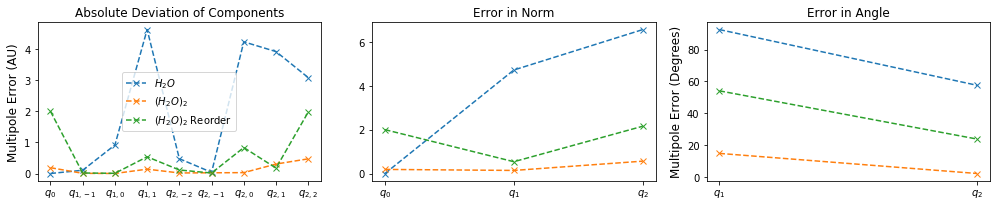

In [29]:
plot_error(reorder.system, {"$H_2O$":rmmm.system, "$(H_2O)_2$ Reorder":rmmm2.system, "$(H_2O)_2$":qmmm2.system})

The above graph shows how a judicious choice of background element is crucial to reduce the error.

## Spillage Calculations
The choice of background is important, and we need a way to automatically determine it. The spillage interaction calculator provides precisely this. It returns an array which shows the spillage between the target fragment and all other fragments.

In [30]:
from BigDFT import Spillage as SP
reload(PP)
reload(SP)

<module 'BigDFT.Spillage' from '/Users/dawson/Documents/CEACollaboration/SourceCode/PurifySteps/BuildFast/install/lib/python2.7/site-packages/BigDFT/Spillage.pyc'>

In [31]:
btool = PP.BigDFTool()
spillage_values = btool.compute_spillage(full.system, full.log, 0)
print(spillage_values)

[1.0, 0.032071212956998066, 0.0]


Thus we see that the first water molecule has significant spillage with itself, and the second water molecule, making it a good choice for the buffer. 